# Bloomberg INDG Challenge- Article Topics and Embeddings

For each article in `challenge.csv`, let's find a description using only the article's embedding.

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from collections import defaultdict
import os

## Read the embedding data

Combine the CNN and Federal articles' data into a Pandas dataframe

In [2]:
# read CNN and federal csvs
df_cnn = pd.read_csv('cnn_samples.csv')
df_fed = pd.read_csv('federal_samples.csv')
# extract numpy arrays from text in csv
df_cnn['embed'] = df_cnn['embedding'].apply(lambda x: np.array([float(s) for s in x[1:-1].split(', ')]).reshape(1,-1))
df_fed['embed'] = df_fed['embeddings'].apply(lambda x: np.array([float(s) for s in x[1:-1].split(', ')]).reshape(1,-1))
df_fed.rename(columns={'embeddings':'embedding'}, inplace=True)
# combine both data frames
df_comb = pd.concat((df_cnn, df_fed), axis=0)
df_cnn.shape, df_fed.shape, df_comb.shape

((738, 5), (120, 5), (858, 5))

## Read the challenge embeddings
(and mystery embedding too)

In [3]:
# read the 5 challenge embeddings
df_cha = pd.read_csv('challenge.csv')
df_cha['embed'] = df_cha['embeddings'].apply(lambda x: np.array([float(s) for s in x[1:-1].split(', ')]).reshape(1,-1))

In [4]:
# read the mystery challenge
df_mys = pd.read_json('mystery.json')
df_mys = pd.DataFrame({'embed': df_mys.T.values.tolist()})
df_mys['embed'] = df_mys['embed'].apply(lambda x: np.array([float(s) for s in x]).reshape(1,-1))

## Find the optimal # of clusters

Use unsupervised K Means Clustering to find the optimal number of clusters, K.

In [5]:
# find the optimal number of clusters using K Means Clustering
# inertia = average square distance to closest centroid
def get_kmeans_inertias(df, K):
    inertias = []
    X = [x for x in df['embed'].values]
    X = np.concatenate(X)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        inertias.append(kmeanModel.inertia_)
    
    return inertias

C:\Users\krish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


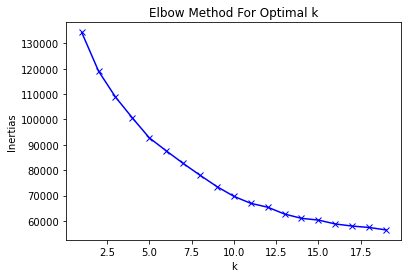

In [6]:
K = range(1, 20)
plt.plot(K, get_kmeans_inertias(df_comb, K), 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('Elbow Method For Optimal k')
plt.show()

After k=11, the inertia reduces slowly, so k=11 is the elbow. **We'll choose 11 clusters going forward.**

## NMF
[Learning the parts of objects by non-negative matrix factorization by Lee and Seung](https://www.nature.com/articles/44565)

Use Non-negative Matrix Factorization to learn how each term is related to the 11 topics and how each article is related to all topics.

NMF finds latent structure by factoring a non-negative data matrix into 2 factors, $W, H$. It can be used as effective topic modeling.
The inputs are a **document-term** matrix $X$ of TF-IDF (term frequency- inverse document frequency) values and number of topics $K$.
The outputs are 2 K-dimensional factors $W, H$ of $X$ that, when multiplied, approximate $X$: $X \approx W H$.
 $W$ is a **document-topic** matrix
 $H$ is a **term-topic** matrix

### Train Test Split
In order to make sure we are on the right track, we'll split the combined dataframe into train and test sets.
We will learn the NMF only using the train data and sanity-check the results with the test data.

In [7]:
# Split combined data into train and test splits in order to validate the process
df_comb_train, df_comb_test = train_test_split(df_comb, train_size=0.8, random_state=42)

In [8]:
# find 1-3 length ngrams and term frequency-inverse document frequency to find were/how often phrases are used in each article
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,3), 
                                   min_df=2,  
                                   max_df=0.95,stop_words='english')
tfidf_documents_train = tfidf_vectorizer.fit_transform(df_comb_train.text)
tfidf_documents_test = tfidf_vectorizer.transform(df_comb_test.text)    
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
NUM_TOPICS = 11
X = tfidf_documents_train

nmf = NMF(n_components=NUM_TOPICS, random_state=0, init="nndsvd")
# find the topic distribution of each document
W = nmf.fit_transform(X)
# find the topic distribution for each term
H = nmf.components_

# show the top 15 most likely terms for each topic
TOP_TERMS = 15
for topic_index in range(NUM_TOPICS):
    # sort terms by their probability of being in the topic_index'th topic
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    # print the top 15 terms in the topic_index'th topic
    for term_index in top_indices[:TOP_TERMS]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)

**NMF Identified Topics**

0. social media
1. occupational safety
2. soccer
3. American politics
4. taxes/COVID
5. national security
6. neighborhood crimes
7. workplace equality
8. securities and trading
9. tennis/golf
10. East Asia diplomacy

#### Validating NMF with test data
**this analysis looks promising**
Most articles line up with their topic label

In [10]:
# repeat the process with test data
W_test = nmf.transform(tfidf_documents_test)

for doc_idx in range(tfidf_documents_test.shape[0]):
    top_indices = np.argsort(W_test[doc_idx, :])[::-1]
    print(top_indices[0], df_comb_test.iloc[doc_idx].text[:80])

6 (CNN) -- Three men who were convicted of killing three Cub Scouts 16 years ago w
3 (CNN) -- Despite the many differences I had with former President George W. Bush
0 Jeddah, Saudi Arabia (CNN) -- At first glance, it looks like a standard road sig
9 (CNN)  -- Cristie Kerr is the first player from the United States to top the wom
5 (CNN) -- Bolivian President Evo Morales is apologizing to the Jewish community i
4 Washington — The U.S. Department of Commerce’s United States Patent and Trademar
6 (CNN) -- Defense attorneys representing accused Boston Marathon bomber Dzokhar T
6 Pretoria, South Africa (CNN) -- Prosecutors in the Oscar Pistorius murder case w
5 THE HAGUE, Netherlands (CNN) -- The chief prosecutor of the International Crimin
4 WASHINGTON – As part of the Obama Administration's efforts to strengthen communi
6 Sao Paulo, Brazil (CNN) -- Rio de Janeiro's special police forces declared Sunda
2 (CNN) -- Spain's Luis Leon Sanchez gave his crash-ravaged Rabobank team a lift o
9 (C

### Additional Validation
The top documents for each topic aligned with the topic label

**this analysis also looks promising**
Each topics' main articles line up with their topic label/ common words

In [11]:
# print the two documents that are most related to each topic
top_docs = 2
for topic_index in range(NUM_TOPICS):
    top_indices = np.argsort(W[:, topic_index])[::-1]
    top_documents = []
    for doc_index in top_indices[0:top_docs]:
        doc = df_comb_train.iloc[doc_index].text
        print(topic_index, doc_index, doc[0:90].replace("\n", ""))
        top_documents.append(doc)

0 398 (CNN) -- Those of us who love travel know it can be a life changer. Since making resolutio
0 553 (CNN) -- Does a special woman in your life spend far too much time thinking for herself? Y
1 14 ALBANY, N.Y. - The U.S. Department of Labor's Occupational Safety and Health Administratio
1 108 JACKSONVILLE, Fla. - The U.S. Department of Labor's Occupational Safety and Health Adminis
2 91 (CNN) -- Arsenal have signed Moroccan international striker Marouane Chamakh from Bordeaux
2 237 (CNN) -- Real Madrid, the kings of Europe, will take on a team living one of the greatest 
3 41 WASHINGTON (CNN) -- Sen. Hillary Clinton on Saturday will officially suspend her campaign 
3 679 (CNN) -- President Obama seems determined to launch a two-front war with the new Republica
4 285 WASHINGTON — The Internal Revenue Service provided additional information to help taxpayer
4 182 WASHINGTON — The Internal Revenue Service today issued proposed regulationsPDF  reducing t
5 254 Rome (CNN) -- The United St

### Likely terms for a Topic (eg tennis/golf)
Ensure that the terms in a given topic are related.

All terms related to tennis (open, grand slam, players) are chosen and many golf terms too (round, tournament).
Using n-grams of size > 1 helped identify phrases like _grand slam_ and _australian open_

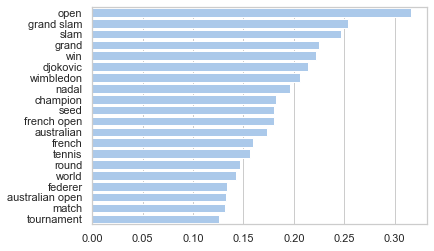

In [12]:
# for the tennis/golf category (9), find the most likely terms
sns.set(style="whitegrid")
topic_index = 9
vocab = np.array(tfidf_feature_names)
top_term_indices = np.array(np.argsort(H[topic_index, :])[::-1])[0:20]

term_strings = vocab[top_term_indices]
term_weights = H[topic_index, top_term_indices]

sns.set_color_codes("pastel")
sns.barplot(x=term_weights, y=term_strings, label="Weight", color="b")

plt.show()

### Get the NMF for Combined Data
We were able to use NMF for finding topics in the train data. We were also able to validate these topics for the train data.

Using the combined data, let's use NMF to find the document-topic and term-topic relationship for all available data.

In [13]:
nmf = NMF(n_components=NUM_TOPICS, random_state=0, init="nndsvd")

# I.1 get W,H from combined data
tfidf_documents_comb = tfidf_vectorizer.fit_transform(df_comb.text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
W = nmf.fit_transform(tfidf_documents_comb)
H = nmf.components_

#### Have NMF identified topics changed after combining train/test data?
**No changes**, the 11 topics have not changed after we combined the train and test data!

In [14]:
# show the top 15 most likely terms for each topic using combined data
for topic_index in range(NUM_TOPICS):
    # sort terms by their probability of being in the topic_index'th topic
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    # print the top 15 terms in the topic_index'th topic
    for term_index in top_indices[:TOP_TERMS]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['people', 'like', 'says', 'just', 'new', 'world', 'time', 'said', 'years', 'really', 'think', 'facebook', 'life', 'don', 'women']
topic  1 ['osha', 'safety', 'health', 'safety health', 'workers', 'occupational', 'occupational safety', 'occupational safety health', 'hazards', 'violations', 'cited', 'violation', 'citations', 'employers', 'labor']
topic  2 ['league', 'club', 'season', 'minutes', 'barcelona', 'arsenal', 'football', 'champions', 'madrid', 'team', 'real', 'liverpool', 'bayern', 'game', 'win']
topic  3 ['obama', 'clinton', 'president', 'democrats', 'republican', 'election', 'party', 'republicans', 'campaign', 'house', 'bush', 'sen', 'vote', 'voters', 'senate']
topic  4 ['eeoc', 'discrimination', 'employment', 'district', 'disability', 'ada', 'employers', 'employee', 'lawsuit', 'sex', 'equal', 'covid', 'employees', 'covid 19', 'federal']
topic  5 ['said', 'al', 'government', 'syria', 'syrian', 'military', 'security', 'forces', 'iraq', 'people', 'united', 'pakistan', 

## Trying the Challenge Articles

Now that we know how documents relate to topics, can we find the terms associated with an embedding?

So far we know
- each CNN/Federal document's embedding
- the topics each document contains ($W$)
- how terms are distributed among documents ($H$)

Can we use this information to convert an embedding from the challenge dataset to terms/phrases?

**We propose a classifier that classifies embeddings based on the terms most likely to appear in that embedding's article.**

### Building the Classifier
Since NMF is repeatable for both train and test, let's combine both and create a classifier

#### Part I: get the 512-embedding for each topic
1. get $W, H$ from NMF(combined_data) [already done above]
2. get top 15 documents for each topic with the argmax across each column of $W$
3. get an average topic embedding using a (weighted) average of the top 15 docs for each topic
4. L2 normalize all average topic embeddings
#### Part II: classify an arbitrary embedding $\vec{e}$ _by topic using 20 words_
1. find the most (cosine) similar avarge topic embedding vector $\vec{t_i} : i = \text{argmax}_{\forall i} \left( \frac{\vec{t_{i}} \bullet \vec{e}}{|\vec{t_i}||\vec{e}|} \right)$
2. save $steps[i] := \frac{\vec{t_{i}} \bullet \vec{e}}{|\vec{t_i}||\vec{e}|}$
3. repeat steps II.1-2 like [Gram-Schmidt](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) (only difference is all $\vec{t_i}$ might not be orthogonal)
4. sample 20 topics from $Softmax(steps)$
5. for each of the 20 sampled topics $s$, sample 1 word from the $s^{th}$ column of $H$

In [17]:
# I.2 get top 15 documents for each topic with the argmax across each column of W
TOP_DOCS = 15
topic_top_docs = [0]*NUM_TOPICS

for topic_index in range(NUM_TOPICS):
    top_indices = np.argsort(W[:, topic_index])[::-1]
    topic_top_docs[topic_index] = top_indices[:TOP_DOCS]

In [18]:
# I.3 get an average topic embedding using a (weighted) average of the top 15 docs for each topic
topic_avg_emb = [0]*NUM_TOPICS

for topic_index in range(NUM_TOPICS):
    topic_avg_emb[topic_index] = 0
    # find weighted average embedding with: 1/i * topic_top_doc[topic_idx][i].embedding
    for pos in range(1, TOP_DOCS+1):
        pos_most_related = topic_top_docs[topic_index][pos-1]
        topic_avg_emb[topic_index] = 1/pos * df_comb.iloc[pos_most_related].embed

In [19]:
# I.4 L2 normalize all average topic embeddings
for k in range(NUM_TOPICS):
    topic_avg_emb[k] = topic_avg_emb[k]/np.linalg.norm(topic_avg_emb[k])

In [ ]:
NUM_TERMS = 20
# II.1 find the most similar avarge embedding vector t_i
def get_most_cos_sim(emb):
    cos_sims = -2*np.ones(NUM_TOPICS)
    for i in range(NUM_TOPICS):
        cos_sims[i] =  cosine_similarity(topic_avg_emb[i], emb).reshape(-1)
    return np.argmax(cos_sims)

# II.2 get the top 20 words from i'th row of H
def get_word_id_in_H(topic_index):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    # print the top 15 terms in the topic_index'th topic
    for term_index in top_indices[:TOP_TERMS]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)
    return top_terms

for embed in df_cha.embed:
    topic_idx = get_most_cos_sim(embed)
    get_word_id_in_H(topic_idx)

In [43]:
NUM_TERMS = 20

# II.1 find the most similar avarge embedding vector t_i,
# II.2 $steps[i] := comp_{\vec{t_i}}{\vec{e}}$
def get_most_cos_sim(emb, topic_avg_emb):
    NUM_TOPICS = len(topic_avg_emb)
    cos_sims = -2*np.ones(NUM_TOPICS)
    for i in range(NUM_TOPICS):
        if topic_avg_emb[i] is not None:
            cos_sims[i] =  cosine_similarity(topic_avg_emb[i], emb).reshape(-1)
    # -cos_sims because argmax returns the minimum by default (we want max cos similarity)
    return np.argmax(cos_sims), np.max(cos_sims)

# II.3 repeat steps II.1-2 like Gram-Schmidt (only difference is all $\vec{t_i}$ might not be orthogonal)
def get_topic_dir_steps(emb, topic_avg_emb):
    NUM_TOPICS = len(topic_avg_emb)
    steps = np.zeros(NUM_TOPICS)
    topic_embs = topic_avg_emb.copy()

    for _ in range(len(topic_avg_emb)):
        most_sim_idx, step_sz = get_most_cos_sim(emb, topic_embs)
        steps[most_sim_idx] = step_sz
        emb = emb - step_sz*topic_avg_emb[most_sim_idx]
        topic_embs[most_sim_idx] = None
    return steps

In [42]:
topic_avg_emb_ex = [np.array([1,-1,1]).reshape(1,-1),
                    np.array([1,0,1]).reshape(1,-1)]
# for k in range(len(topic_avg_emb_ex)):
#     topic_avg_emb_ex[k] = topic_avg_emb_ex[k]/np.linalg.norm(topic_avg_emb_ex[k])

emb_ex = np.array([1,1,2]).reshape(1,-1)
get_topic_dir_steps(emb_ex, topic_avg_emb_ex)

array([0.8660254, 2.       ])

In [20]:
topic_avg_emb[0].shape

(1, 512)

In [ ]:
N_term_classifier(df_cha.iloc[0].embed)

In [ ]:
def find_closest(tgt):
    max_score = -2
    for i in range(NUM_TOPICS):
        score = cosine_similarity(sent_dict[i], tgt)
        if score > max_score:
            max_score = score
            most_related = i
    return max_score, most_related

In [44]:
for i, ch in enumerate(df_comb_test.embed):
    print(i, find_closest(ch))

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 24503 while Y.shape[1] == 512

## KNN

In [8]:
# Create a 10 Nearest Neighbors classifier
X = [x for x in df_cnn['embed'].values]
X = np.concatenate(X)
kmeanModel = KMeans(n_clusters=10).fit(X)
cdist = kmeanModel.transform(X)
classes = kmeanModel.predict(X)

In [9]:
# use softmax to get a probability distribution for each class using distance from all centroids
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

softmax(max(cdist[1]) - cdist[1])

array([1.12911571e-02, 5.06827704e-05, 4.03350536e-03, 5.73066830e-02,
       1.38935278e-03, 1.63721594e-02, 2.03328716e-03, 8.28167184e-03,
       8.96812257e-01, 2.42924316e-03])

In [10]:
# find all the articles that are close to their centroids
incl_cdist = defaultdict(list)
THRESHOLD =  0.75
for i in range(len(cdist)):
    max_class_prob = max(softmax(max(cdist[i]) - cdist[i]))
    if max_class_prob > THRESHOLD:
        incl_cdist[classes[i]].append(i)

## LDA

In [86]:
tf_vectorizer = CountVectorizer(ngram_range = (1,3), 
                                   min_df=2,  
                                   max_df=0.95,stop_words='english')
tf_documents_train = tf_vectorizer.fit_transform(df_comb_train.text)
tf_documents_test = tf_vectorizer.transform(df_comb_test.text)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [87]:
lda = LatentDirichletAllocation(n_components = NUM_TOPICS, random_state=42)
W = lda.fit_transform(tf_documents_train)
H = lda.components_

In [88]:
top = 15
topic_index_max = NUM_TOPICS

for topic_index in range(0, topic_index_max):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['said', 'cnn', 'year', 'state', 'time', 'world', 'people', 'told', 'like', 'government', 'court', 'new', 'just', 'years', 'united']
topic  1 ['obama', 'said', 'president', 'clinton', 'cnn', 'republican', 'health', 'people', 'house', 'party', 'republicans', 'democrats', 'campaign', 'election', 'care']
topic  2 ['said', 'health', 'safety', 'osha', 'people', 'north', 'workers', 'cnn', 'korea', 'south', 'united', 'safety health', 'according', 'government', 'report']
topic  3 ['said', 'cnn', 'people', 'new', 'time', 'just', 'world', 'years', 'bank', 'year', 'billion', 'says', 'like', '000', 'money']
topic  4 ['said', 'police', 'cnn', 'told', 'authorities', 'people', 'school', 'according', 'china', 'report', 'officials', 'state', 'security', 'reported', 'year']
topic  5 ['said', 'program', 'cnn', 'president', 'flight', 'border', 'years', 'office', 'million', 'los angeles', 'angeles', 'los', 'year', 'school', 'people']
topic  6 ['said', 'people', 'time', 'world', 'year', 'cnn', 'say

In [89]:
W_test = lda.transform(tf_documents_test)

for doc_idx in range(tf_documents_test.shape[0]):
    top_indices = np.argsort(W_test[doc_idx, :])[::-1]
    print(top_indices[0], df_comb_test.iloc[doc_idx].text[:80])

0 (CNN) -- Three men who were convicted of killing three Cub Scouts 16 years ago w
1 (CNN) -- Despite the many differences I had with former President George W. Bush
0 Jeddah, Saudi Arabia (CNN) -- At first glance, it looks like a standard road sig
0 (CNN)  -- Cristie Kerr is the first player from the United States to top the wom
8 (CNN) -- Bolivian President Evo Morales is apologizing to the Jewish community i
2 Washington — The U.S. Department of Commerce’s United States Patent and Trademar
4 (CNN) -- Defense attorneys representing accused Boston Marathon bomber Dzokhar T
4 Pretoria, South Africa (CNN) -- Prosecutors in the Oscar Pistorius murder case w
4 THE HAGUE, Netherlands (CNN) -- The chief prosecutor of the International Crimin
9 WASHINGTON – As part of the Obama Administration's efforts to strengthen communi
0 Sao Paulo, Brazil (CNN) -- Rio de Janeiro's special police forces declared Sunda
6 (CNN) -- Spain's Luis Leon Sanchez gave his crash-ravaged Rabobank team a lift o
0 (C

# Bloomberg API

In [156]:
import requests
import json

def get_embedding(text, api_key):
    ## API Definitions
    url = "https://datathon.bindgapi.com/channel"
    headers =  {
        "X-API-Key": api_key,
        "Content-Type":"application/json"
    }
    body = { "inputs": text }
    ## API Call
    try:
        response = requests.post(url, data=json.dumps(body), headers=headers)
    except Exception:
        print(Exception)
        
    try:
        # return response 
        result = response.json()
        return json.loads(result['results'])
    except:
        print(response.status_code)
        
API_KEY = 'PVFrBRKkTt9RSFx96LxKX7vxINpi1N7laJebYRoh'
emb = get_embedding(df.iloc[0].text, API_KEY)